In [1]:
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 02:18:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/10 02:18:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/10 02:18:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### dataset

In [4]:
trans_sdf = read_file(spark, 'changed_data', '../data/curated/')

|> Loading File...


|> Loading Finished!


-RECORD 0-------------------------------------------------------------------------------------------
 user_id         | 9521                                                                             
 merchant_abn    | 10023283211                                                                      
 dollar_value    | 86.95574860858353                                                                
 order_id        | c6c473f9-e796-4c1c-b952-4df1c93f3b4a                                             
 tags            | furniture, home furnishings and equipment shops, and manufacturers, except ap... 
 take_rate       | 0.18                                                                             
 type            | e                                                                                
 postcode        | 4753                                                                             
 consumer_id     | 838133                                                                  

In [5]:
merchant_fraud_sdf = read_file(spark,'merchant_fraud_probability.csv', '../data/tables/', 'csv')
merchant_fraud_sdf.count()

|> Loading File...
|> Loading Finished!
-RECORD 0-------------------------------
 merchant_abn      | 19492220327        
 order_datetime    | 2021-11-28         
 fraud_probability | 44.403658647495355 
only showing top 1 row



114

Feature Attribute

In [6]:
sdf = trans_sdf.select( 'user_id', 'merchant_abn', 'order_datetime', 'dollar_value', 'take_rate', 'consumer_id', 'POA_CODE21', 'longitude', 'latitude', 'genderIndex', 'typeIndex', 'tagIndex', 'tag_vec', 'New_cases_daily')

In [7]:
import pyspark.sql.functions as F
from pyspark.sql.functions import datediff

In [8]:
sdf_merchant = sdf.groupby('merchant_abn').agg(
    (F.count("*") / F.datediff(F.max('order_datetime'), F.min('order_datetime'))).alias('sales_frequency'),
    (F.datediff(F.max('order_datetime'),F.min('order_datetime')) / F.count("*")).alias('single_sale_duration'),
    (F.count("*")).alias("total_sales"),
    (F.avg("dollar_value")).alias('sales_average')
)

In [9]:
sdf_merchant.show(5)

+------------+------------------+--------------------+-----------+------------------+
|merchant_abn|   sales_frequency|single_sale_duration|total_sales|     sales_average|
+------------+------------------+--------------------+-----------+------------------+
| 15613631617|2.9267399267399266| 0.34167709637046306|       1598|303.59594789409743|
| 19839532017|1.2311926605504586|   0.812220566318927|        671|             157.0|
| 35344855546| 2.457875457875458|  0.4068554396423249|       1342| 86.84866375872545|
| 38700038932|11.615384615384615| 0.08609271523178808|       6342|1337.2767986337328|
| 41956465747|0.4540441176470588|  2.2024291497975708|        247|226.22034040135608|
+------------+------------------+--------------------+-----------+------------------+
only showing top 5 rows



In [10]:
sdf_daily = sdf.groupby('merchant_abn', 'order_datetime', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec', 'New_cases_daily').agg(
    F.count("*").alias("daily_sales"), 
    F.avg("dollar_value").alias("daily_average"),
    F.min("dollar_value").alias("trans_min"),
    F.max("dollar_value").alias("trans_max"),
    )

In [11]:
sdf_daily.count()

1204427

In [12]:
sdf_daily = sdf_daily.join(sdf_merchant, on=['merchant_abn'], how = 'left')

In [13]:
sdf_daily.count()

1204427

In [14]:
from pyspark.sql.functions import year, month, dayofmonth

In [15]:
sdf_daily = (sdf_daily
                .withColumn('order_year', year(sdf_daily.order_datetime))
                .withColumn('order_month', month(sdf_daily.order_datetime))
                .withColumn('order_day', dayofmonth(sdf_daily.order_datetime))
                )

In [16]:
sdf_daily = (sdf_daily
                    .withColumn('daily_sales', sdf_daily['daily_sales'].cast('double'))
                    .withColumn('total_sales', sdf_daily['total_sales'].cast('double'))
                    )

- join data

In [17]:
train_data = sdf_daily.join(merchant_fraud_sdf, on=['merchant_abn', 'order_datetime'], how = 'inner')

In [18]:
trans_data = sdf_daily.join(merchant_fraud_sdf, on=['merchant_abn', 'order_datetime'], how = 'outer')

In [19]:
train_data.count()

114

In [20]:
trans_data.count()

1204427

In [21]:
train_data = (train_data
                .withColumn('fraud_probability', train_data['fraud_probability'].cast('double')))

- Test Data

In [22]:
trans_data = trans_data.drop('fraud_probability')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
train_corr = train_data.toPandas()

In [25]:
columns = ['merchant_abn', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec', 'daily_sales', 'daily_average', 'trans_min', 'trans_max','total_sales','sales_average','sales_frequency', 'single_sale_duration', 'fraud_probability']
corr = train_corr[columns].corr(method='spearman')

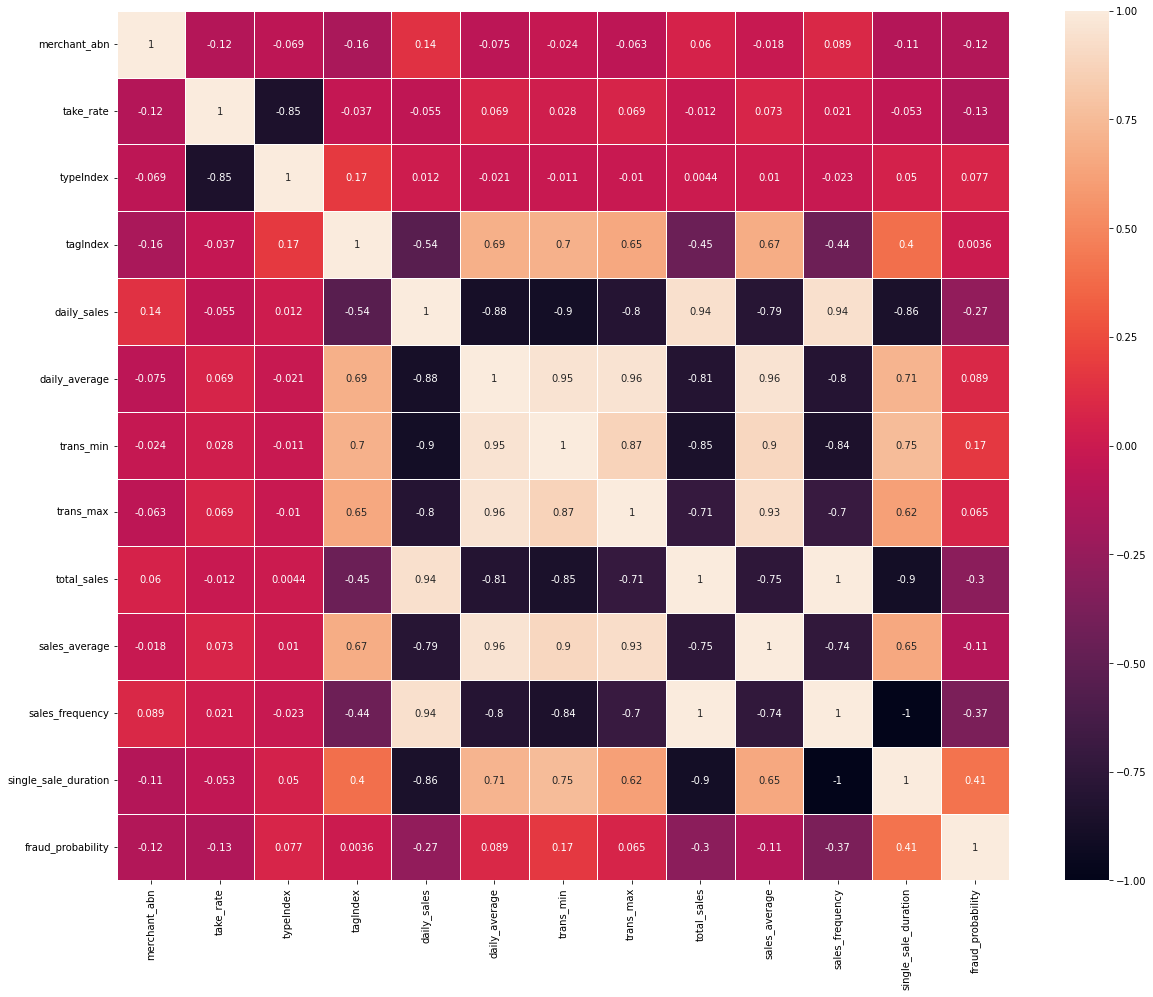

In [26]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(corr,annot = True, linewidths=1)
plt.show()

### Feature Engineering

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [28]:
input_col = ['take_rate', 'tag_vec', 'daily_sales', 'daily_average', 'New_cases_daily', 'trans_min', 'trans_max','total_sales','sales_average']

In [29]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [30]:
train_dataset = vecAssembler.transform(train_data)

In [31]:
test_dataset = vecAssembler.transform(trans_data)

In [32]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

### Decision Tree Regression Model

In [33]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Using a decision tree model
dt = DecisionTreeRegressor(featuresCol="features")


model = dt.fit(train_dataset)

# Predictions
dfpredictions = model.transform(train_dataset)
dfpredictions.select("prediction", "label", "features").show(5)

# Evaluation
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(dfpredictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 32.78610817270478| 46.45775596795885|(32,[0,22,25,26,2...|
| 32.78610817270478| 28.98838429202166|(32,[0,22,25,26,2...|
| 44.43787807900269| 44.43787807900268|(32,[0,22,25,26,2...|
|23.943274591766023|25.054391991473924|(32,[0,25,26,27,2...|
| 32.78610817270478|24.872618445353506|(32,[0,25,26,27,2...|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 4.948


In [34]:
test_dt_prediction = model.transform(test_dataset)

In [35]:
test_dt_prediction = test_dt_prediction.withColumnRenamed('prediction', 'fraud_probability')

In [36]:
test_dt_prediction.agg(
    F.mean('fraud_probability'), 
    F.max('fraud_probability'),
    F.min('fraud_probability'), 
).show()

+----------------------+----------------------+----------------------+
|avg(fraud_probability)|max(fraud_probability)|min(fraud_probability)|
+----------------------+----------------------+----------------------+
|     49.23671829673013|     94.13470048088911|     18.21089142894488|
+----------------------+----------------------+----------------------+



In [37]:
train_dataset.limit(5)

merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,New cases / day,daily_sales,daily_average,trans_min,trans_max,sales_frequency,single_sale_duration,total_sales,sales_average,order_year,order_month,order_day,label,features
14827550074,2021-11-26,4.248542756219157,1.0,21.0,"(24,[21],[1.0])",1621.0,9.0,7434.455583426204,594.1572766659802,23232.211150027288,2.347985347985348,0.42589703588143524,1282.0,4733.581650588678,2021,11,26,46.45775596795885,"(32,[0,22,25,26,2..."
93260930990,2021-11-28,3.15,1.0,21.0,"(24,[21],[1.0])",1236.0,10.0,4189.261960580331,1903.0947079530436,8918.141987820347,3.899267399267399,0.2564584311883513,2129.0,3711.578203133962,2021,11,28,28.98838429202166,"(32,[0,22,25,26,2..."
29674997261,2021-12-26,3.6745166860335354,1.0,21.0,"(24,[21],[1.0])",9374.0,1.0,46337.713978159205,46337.713978159205,46337.713978159205,0.012958963282937365,77.16666666666667,6.0,23677.68097131452,2021,12,26,44.43787807900268,"(32,[0,22,25,26,2..."
15043504837,2021-10-08,4.62,1.0,24.0,"(24,[],[])",2510.0,2.0,21857.365760481523,11966.825863344562,31747.90565761848,0.3252788104089219,3.0742857142857143,175.0,16222.073064587443,2021,10,8,25.054391991473924,"(32,[0,25,26,27,2..."
19492220327,2021-11-03,4.93,1.0,24.0,"(24,[],[])",1110.0,3.0,13886.322330489382,6012.997382959105,28809.63925919443,1.3517495395948436,0.7397820163487738,734.0,9935.265132054748,2021,11,3,24.872618445353506,"(32,[0,25,26,27,2..."


In [38]:
final_train = train_dataset.select('merchant_abn', 'order_datetime', 'label').withColumnRenamed('label', 'fraud_probability')

In [39]:
final_test = test_dt_prediction.select('merchant_abn', 'order_datetime', 'fraud_probability')

In [40]:
dt = final_train.union(final_test)

In [41]:
dt.write.parquet('../data/curated/merchants_fraud.parquet', mode = 'overwrite')

### Linear Reg Model

In [42]:
lr = LinearRegression(featuresCol='features',labelCol='label', maxIter=5, regParam=0.0, solver="normal")
lr_model=lr.fit(train_dataset)

22/10/10 02:24:28 WARN Instrumentation: [5e0a2a69] regParam is zero, which might cause numerical instability and overfitting.


22/10/10 02:24:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/10 02:24:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/10 02:24:29 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/10/10 02:24:29 WARN Instrumentation: [5e0a2a69] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [43]:
print("Correlation coefficient:{}".format(lr_model.coefficients))
print("Intercept:{}".format(lr_model.intercept))

Correlation coefficient:[0.40025237341417896,2.938694757340567,33.70607420686052,21.98758057109375,0.0,45.04604354706478,22.17266813174563,17.84617293393413,17.272630217865302,6.283257112421345,9.035953370387999,9.8087219941388,10.971261710031055,21.74779026519353,0.0,0.8177024807408046,3.7574866399003457,6.142651205791583,0.0,3.026929742514629,-0.2910673836155278,-2.8905529451252963,-0.8510055936760412,0.0,4.124165154199979,-0.05138487757120158,0.00033568131871820255,-7.020638130049985e-05,0.0004810713003542449,2.8452663929716057e-05,-0.00025193614055916866,-0.001441017464948993]
Intercept:39.51692360033173


In [44]:
training_predictions=lr_model.evaluate(train_dataset) 

In [45]:
print('{}{}'.format('Mean Square Error:',training_predictions.meanSquaredError))
print('{}{}'.format('R2 determination factor：',training_predictions.r2 ))

Mean Square Error:128.63613639464228
R2 determination factor：0.5607097117265689


In [46]:
test_pred = lr_model.transform(test_dataset)

In [47]:
test_pred = test_pred.withColumnRenamed('prediction', 'fraud_probability')

In [48]:
test_pred.agg(
    F.mean('fraud_probability'), 
    F.max('fraud_probability'),
    F.min('fraud_probability'), 
).show()

+----------------------+----------------------+----------------------+
|avg(fraud_probability)|max(fraud_probability)|min(fraud_probability)|
+----------------------+----------------------+----------------------+
|    50.180159645144975|     96.74081785822557|    -72.92382406111867|
+----------------------+----------------------+----------------------+



### GLM Model

In [49]:
from pyspark.ml.regression import GeneralizedLinearRegression

In [50]:
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
 
# Fit the model
glr_model = glr.fit(train_dataset)
 
# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(glr_model.coefficients))
print("Intercept: " + str(glr_model.intercept))
 
# Summarize the model over the training set and print out some metrics
summary = glr_model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

Coefficients: [-0.1492324313582948,3.7793571069407514,37.7914322689839,21.434254867117716,0.0,56.06708590848219,21.734659714602095,24.167733325141658,18.396315848599244,9.87829388491512,9.93618820523373,10.696749057144494,12.371828606837134,21.281019247035655,0.0,3.750318758656226,6.755702426240873,7.0766260766931,0.0,3.2814898113841866,2.3213107767387426,-1.1553910071211466,-0.8082190638416068,0.0,3.2863289065572925,-0.050951992695918734,0.00039617263265578326,-5.037762435290084e-05,0.00037809871845779624,-8.207786343727333e-05,-0.00040151958409831364,-0.0012322344284572374]
Intercept: 42.65214099584176


Coefficient Standard Errors: [1.1665057335042992, 7.865033298451538, 12.265365512299283, 10.361580552702446, inf, 21.538441610477413, 10.256739589030614, 12.707932161501814, 10.388704230336131, 14.687882550637056, 7.315929830493991, 10.373821377103692, 10.405213204074297, 13.827124072554286, inf, 11.178460980108634, 14.541329658781159, 8.826775308828715, inf, 13.760774991840071, 9.393874188408427, 3.9343027320840456, 3.9746262748578656, inf, 7.8318886886404355, 0.07700673705138948, 0.00036132043705429905, 0.00010845988710861438, 0.0002557964777369367, 0.0002245513889589821, 0.00039805311583118746, 0.00022865615845595478, 6.539782919411951]
T Values: [-0.12793115976377223, 0.4805265233504897, 3.0811501076823156, 2.0686279239056207, 0.0, 2.603117111370224, 2.119061279263334, 1.90178331281598, 1.7707998457478487, 0.6725471728725574, 1.3581579423873196, 1.0311290958559922, 1.1890028934719745, 1.539077767391756, 0.0, 0.335495088754139, 0.46458629195310674, 0.8017226936336443, 0.0, 0.2384669

Null Deviance: 33382.29854027973
Residual Degree Of Freedom Null: 113
Deviance: 14052.520883778156
Residual Degree Of Freedom: 81


AIC: 940.3548696877607
Deviance Residuals: 


+--------------------+
|   devianceResiduals|
+--------------------+
|  10.872587159520727|
|  -8.032545739980232|
|  0.7697039964019439|
|  -7.198411884827326|
|  -9.707994239846048|
|  -7.854487350391668|
|  -11.31972291833057|
|  -8.055935911264001|
|-0.40720223404273526|
|  -6.011203590416784|
|   11.36588892422759|
|  -8.767115719932779|
|   4.066712317796398|
|   6.373587042048975|
|  20.276093259968192|
| -3.0344655223068813|
| -1.5000357323238305|
|  32.336951647083225|
|  30.127646763619282|
|  -7.068436658314937|
+--------------------+
only showing top 20 rows



In [51]:
train_glr_pred = glr_model.transform(train_dataset)

In [52]:
test_glr_pred = glr_model.transform(test_dataset)

In [53]:
test_glr_pred = test_glr_pred.withColumnRenamed('prediction', 'fraud_probability')

In [54]:
test_glr_pred.agg(
    F.mean('fraud_probability'), 
    F.max('fraud_probability'),
    F.min('fraud_probability'), 
).show()

+----------------------+----------------------+----------------------+
|avg(fraud_probability)|max(fraud_probability)|min(fraud_probability)|
+----------------------+----------------------+----------------------+
|    52.361087009882844|      98.8137245368043|   -104.52857181520253|
+----------------------+----------------------+----------------------+

